In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier as rf 
from sklearn.metrics import accuracy_score 

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

Failed to load image: dataset\train\BIRD OF PARADISE\.ipynb_checkpoints
Model Training Complete. Accuracy: 0.7692


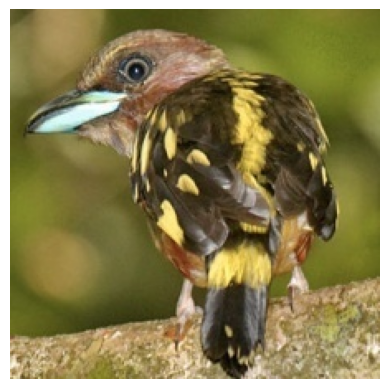

Predicted  Class: BANDED BROADBILL


In [32]:
 
dataset_path = r"dataset\train" 
classes = os.listdir(dataset_path)  # Get class names from dataset folder 
 
def extract_sift_features(image): 
    sift = cv2.SIFT_create() 
    keypoints, descriptors = sift.detectAndCompute(image, None) 
    if descriptors is None: 
        return np.zeros((128,)) 
    return np.mean(descriptors, axis=0)  # Take mean for fixed-length feature 
 
def extract_hog_features(image): 
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                      orientations=9, visualize=True) 
    return features 
def extract_gloh_features(image): 
    sift = cv2.SIFT_create() 
    keypoints, descriptors = sift.detectAndCompute(image, None) 
    if descriptors is None: 
        return np.zeros((128,)) 
    return np.var(descriptors, axis=0) 
X, y = [], [] 
for label, flower in enumerate(classes): 
    flower_path = os.path.join(dataset_path, flower) 
    for img_name in os.listdir(flower_path): 
        img_path = os.path.join(flower_path, img_name) 
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue  # Skip to the next image

        image = cv2.resize(image, (128, 128)) 
         
        sift_feat = extract_sift_features(image) 
        hog_feat = extract_hog_features(image) 
        gloh_feat = extract_gloh_features(image) 
         
        features = np.hstack((sift_feat, hog_feat, gloh_feat)) 
        X.append(features) 
        y.append(label) 
X = np.array(X) 
y = np.array(y) 
 
scaler = StandardScaler() 
X = scaler.fit_transform(X) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
clf = rf(n_estimators=100, random_state=42) 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred) 
print(f"Model Training Complete. Accuracy: {accuracy:.4f}") 
def classify_image(image_path): 
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, (128, 128)) 
    sift_feat = extract_sift_features(image) 
    hog_feat = extract_hog_features(image) 
    gloh_feat = extract_gloh_features(image) 
    features = np.hstack((sift_feat, hog_feat, gloh_feat)).reshape(1, -1) 
    features = scaler.transform(features) 
    pred_label = clf.predict(features)[0] 
    predicted_class = classes[pred_label] 
    print(f"Predicted  Class: {predicted_class}") 
t = "dataset/test/BANDED BROADBILL/3.jpg" 
image = cv2.imread(t) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
 
plt.axis('off') 
plt.imshow(image) 
plt.show() 
 
classify_image(t) 

Good Matches Found: 49


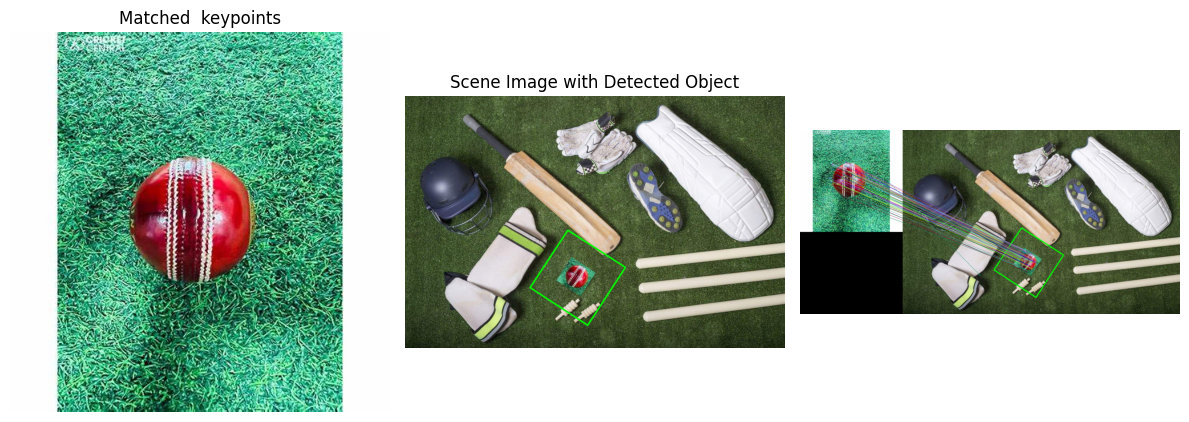

In [3]:
 
MIN_MATCH_COUNT = 3  # Adjusted to avoid false negatives 
 
# Load images 
img_scene = cv2.imread("images/Untitled design.jpg")  # Scene 
img_template = cv2.imread("images/ball.jpg")  # Template 
 
# Convert to grayscale 
gray_scene = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY) 
gray_template = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY) 
 
# Initialize SIFT 
sift = cv2.SIFT_create() 
 
# Detect keypoints and descriptors 
kp1, des1 = sift.detectAndCompute(gray_template, None) 
kp2, des2 = sift.detectAndCompute(gray_scene, None) 
 
# Use FLANN matcher 
FLANN_INDEX_KDTREE = 1 
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) 
search_params = dict(checks=50) 
flann = cv2.FlannBasedMatcher(index_params, search_params) 
 
# Convert descriptors to float 
des1 = np.float32(des1) 
des2 = np.float32(des2) 
 
matches = flann.knnMatch(des1, des2, k=2) 
 
# Apply Lowe’s ratio test 
good_matches = [] 
for m, n in matches: 
    if m.distance < 0.7 * n.distance:  # Adjusted from 0.5 to 0.7 
        good_matches.append(m) 
 
print(f"Good Matches Found: {len(good_matches)}") 
 
if len(good_matches) >= MIN_MATCH_COUNT: 
    # Extract matched keypoints 
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2) 
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2) 
 
    # Compute homography 
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) 
     
    if M is not None: 
        h, w = gray_template.shape[:2] 
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2) 
        dst = cv2.perspectiveTransform(pts, M) 
         
        # Draw the bounding box 
        img_scene = cv2.polylines(img_scene, [np.int32(dst)], True, (0, 255, 0), 3, 
cv2.LINE_AA) 
    else: 
        
        print("Homography matrix is None. No bounding box drawn.") 
 
else: 
    print("Not enough good matches found to compute homography.") 
 
# Draw matches for visualization 
img_matches = cv2.drawMatches(img_template, kp1, img_scene, kp2, good_matches, None, 
flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) 
 
# Convert images for display 
img_template_rgb = cv2.cvtColor(img_template, cv2.COLOR_BGR2RGB) 
img_scene_rgb = cv2.cvtColor(img_scene, cv2.COLOR_BGR2RGB) 
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB) 
 
# Display results 
plt.figure(figsize=(12, 6)) 
plt.subplot(131) 
plt.title('Template Image') 
plt.title('Matched  keypoints')
plt.imshow(img_template_rgb) 
plt.axis('off') 
 
plt.subplot(132) 
plt.title('Scene Image with Detected Object') 
plt.imshow(img_scene_rgb) 
plt.axis('off') 
 
plt.subplot(133) 
plt.imshow(img_matches_rgb) 
plt.axis('off') 
 
plt.tight_layout() 
plt.show() 